<a href="https://colab.research.google.com/github/qedir314/Neural-Networks-Zero-to-Hero/blob/main/makemore_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('/content/names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3

def build_dataset(words):
  X, Y = [], []

  for word in words:
    context = [0] * block_size
    for ch in word + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
n_embd = 10     # dimensionality of the character emb vectors
n_hidden = 200  # number of neurons in the hidden layer

g = torch.Generator().manual_seed(123131)
C = torch.randn((vocab_size, n_embd),                 generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden),     generator = g) * 0.2
b1 = torch.randn(n_hidden,                            generator = g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),              generator = g) * 0.01
b2 = torch.randn(vocab_size,                          generator = g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

11897


In [7]:
max_steps = 100000
batch_size = 32
lossi = []
for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]    # batch

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1   # hidden layer pre-activation
  h = torch.tanh(hpreact)      # hidden layer
  logits = h @ W2 + b2         # output layer
  loss = F.cross_entropy(logits, Yb)   # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

  # track
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 100000: 3.3154
  10000/ 100000: 2.1892
  20000/ 100000: 2.3023
  30000/ 100000: 1.9736
  40000/ 100000: 2.1848
  50000/ 100000: 2.2513
  60000/ 100000: 2.1864
  70000/ 100000: 1.9783
  80000/ 100000: 2.1384
  90000/ 100000: 1.8591


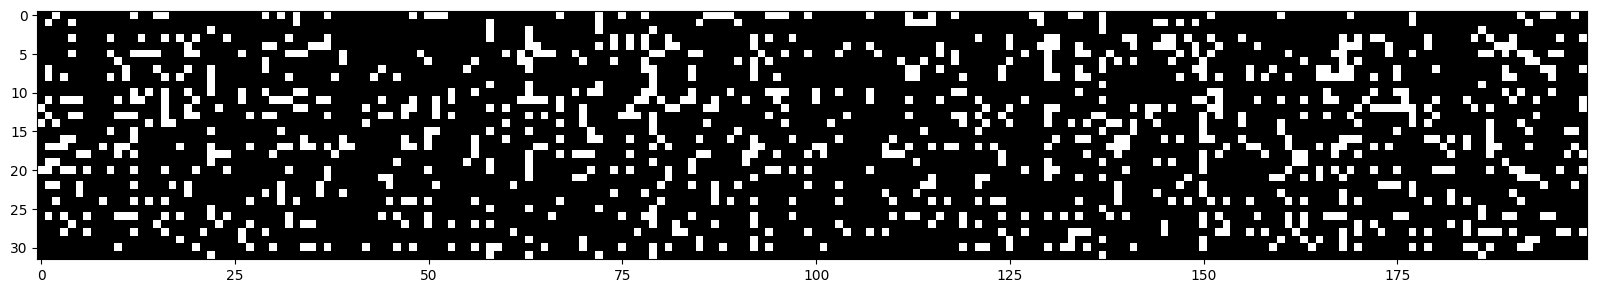

In [8]:
# white -> true, black -> false
# should run after when i == 1
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

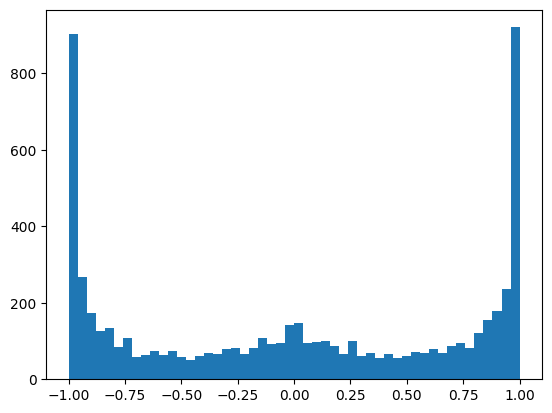

In [9]:
plt.hist(h.view(-1).tolist(), 50);

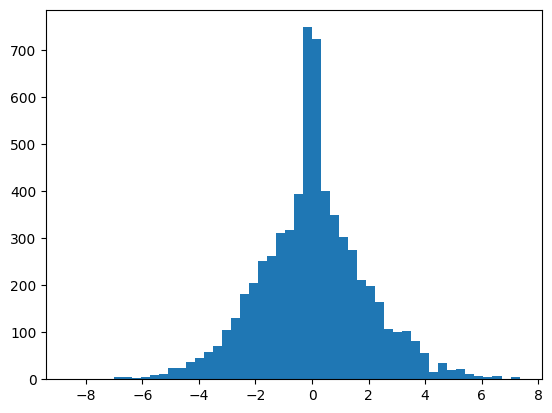

In [10]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [11]:
-torch.tensor(1/27.0).log()    # first loss should be

tensor(3.2958)

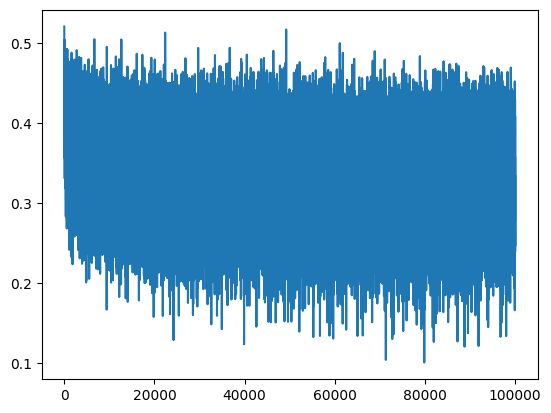

In [12]:
plt.plot(lossi)

In [13]:
@torch.no_grad() # disables gradient tracking
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xval, Yval),
      'test': (Xtest, Ytest)
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1378002166748047
val 2.1881747245788574


In [14]:
g = torch.Generator().manual_seed(323232)

for _ in range(20):

  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()

    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

lwoazea.
ing.
jon.
tifa.
faten.
borcaellynn.
miroluwan.
evane.
arthika.
eawshawn.
hosh.
brawsun.
amon.
gari.
tanaren.
dalery.
asu.
nalyne.
tta.
perin.


## Kaiming init

In [15]:
n_embd = 10     # dimensionality of the character emb vectors
n_hidden = 200  # number of neurons in the hidden layer

g = torch.Generator().manual_seed(123131)
C = torch.randn((vocab_size, n_embd),                 generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden),     generator = g) * (5/3) / (n_embd * block_size)**0.5 # * 0.2
b1 = torch.randn(n_hidden,                            generator = g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),              generator = g) * 0.01
b2 = torch.randn(vocab_size,                          generator = g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

11897


tensor(0.0115) tensor(1.0032)
tensor(3.4177e-05) tensor(1.0047)


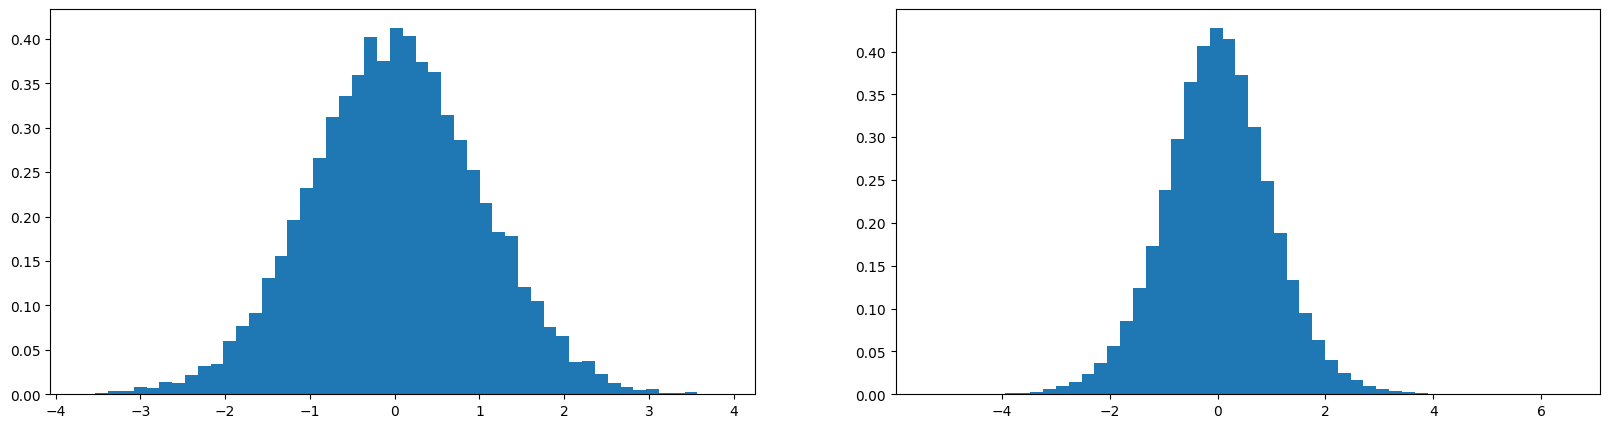

In [16]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [17]:
max_steps = 100000
batch_size = 32
lossi = []
for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]    # batch

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1   # hidden layer pre-activation
  h = torch.tanh(hpreact)      # hidden layer
  logits = h @ W2 + b2         # output layer
  loss = F.cross_entropy(logits, Yb)   # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

  # track
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())


      0/ 100000: 3.3191
  10000/ 100000: 2.1827
  20000/ 100000: 2.3454
  30000/ 100000: 2.0012
  40000/ 100000: 2.1692
  50000/ 100000: 2.3152
  60000/ 100000: 2.1931
  70000/ 100000: 1.9969
  80000/ 100000: 2.0814
  90000/ 100000: 1.7459


In [18]:
split_loss('train')
split_loss('val')

train 2.139573812484741
val 2.1885857582092285


## Batch normalization

In [19]:
n_embd = 10     # dimensionality of the character emb vectors
n_hidden = 200  # number of neurons in the hidden layer

g = torch.Generator().manual_seed(123131)
C = torch.randn((vocab_size, n_embd),                 generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden),     generator = g) * (5/3) / (n_embd * block_size)**0.5 # * 0.2
# b1 = torch.randn(n_hidden,                            generator = g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),              generator = g) * 0.01
b2 = torch.randn(vocab_size,                          generator = g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]   # no need b1
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12097


In [20]:
max_steps = 100000
batch_size = 32
lossi = []
for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]    # batch

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  # linear layer
  hpreact = embcat @ W1 # + b1   # hidden layer pre-activation
  # BatchNorm layer
  bnmeani = hpreact.mean(0, keepdims=True)
  bnstdi = hpreact.std(0, keepdims=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


  h = torch.tanh(hpreact)      # hidden layer
  logits = h @ W2 + b2         # output layer
  loss = F.cross_entropy(logits, Yb)   # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())


      0/ 100000: 3.3091
  10000/ 100000: 2.1196
  20000/ 100000: 2.4439
  30000/ 100000: 2.4255
  40000/ 100000: 2.2255
  50000/ 100000: 2.5467
  60000/ 100000: 2.2136
  70000/ 100000: 2.4311
  80000/ 100000: 2.1514
  90000/ 100000: 2.4805


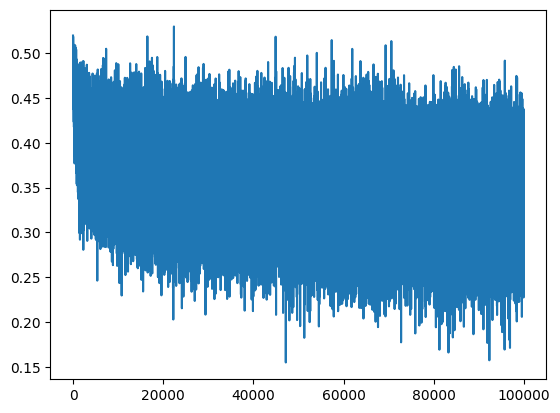

In [21]:
 plt.plot(lossi);

In [22]:
hpreact.shape

torch.Size([32, 200])

In [23]:
hpreact.mean(0, keepdims=True).shape

torch.Size([1, 200])

In [24]:
hpreact.std(0, keepdims=True).shape

torch.Size([1, 200])

In [25]:
# Calibrate the batch norm at the end of training

with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1

  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [26]:
bnmean

tensor([[ 1.1129e+00,  1.1514e+00, -6.3066e-02, -9.4264e-02,  1.9491e+00,
         -1.1336e+00, -1.2565e-01,  6.5746e-01,  1.3578e-01, -8.6053e-01,
          1.5068e-01, -7.4565e-01,  9.8324e-01, -2.9077e-01,  9.2486e-01,
          7.9558e-01, -4.2151e-01, -1.4720e+00, -3.4754e-01,  6.6688e-01,
          3.8496e-01,  9.8929e-01,  2.4208e+00, -5.0465e-01, -9.9230e-01,
          2.8763e-01,  5.6911e-01,  7.8271e-01, -3.6923e-01, -1.3828e+00,
         -1.5715e-01, -1.8844e-01,  1.4406e-01,  5.9810e-01,  1.5634e+00,
          6.1435e-01,  7.7094e-01,  4.6889e-01, -1.0255e-01,  3.8074e-01,
          6.1357e-01, -5.9104e-01, -1.3177e-01, -1.0372e-01,  1.4619e+00,
          5.0621e-01, -3.1414e-01,  1.4035e-01,  5.6220e-01,  2.6625e-01,
         -1.4527e+00, -1.5134e-01, -7.1177e-01,  2.9621e-01, -1.4855e-01,
         -8.2163e-01,  1.2934e+00, -1.1669e-01, -1.4818e+00,  5.7173e-01,
         -9.5291e-01,  1.0257e-01,  2.4329e-01,  4.0446e+00,  4.7811e-01,
         -6.9629e-01, -1.3420e+00,  8.

In [27]:
bnmean_running

tensor([[ 0.6499,  1.2104, -0.0662, -0.0043,  1.3756, -0.6848, -0.1569,  0.6049,
          0.2778, -0.9973, -0.0286, -0.5325,  0.3047,  0.2120,  0.8306,  0.3293,
         -0.1227, -1.3588, -0.5279,  0.5255,  0.3279,  0.7505,  1.2266, -0.6097,
         -1.0416,  0.0189,  0.3015,  0.3538,  0.0701, -0.8156, -0.3603, -0.1331,
          0.0192,  0.4405,  1.2145,  0.5366,  0.7361,  0.1776, -0.3746, -0.4191,
          0.2515, -0.5029,  0.3817, -0.2453,  1.1279,  0.2735, -0.3592, -0.1277,
          0.5058,  0.3092, -1.1367,  0.3302, -0.7291,  0.3126, -0.0509, -0.5651,
          0.7994,  0.3191, -0.6408,  0.5271, -0.4806, -0.0604, -0.0512,  2.5309,
          0.5037, -0.3986, -0.9979,  0.7292,  0.0818,  0.4726, -2.2775, -0.4363,
          0.2754, -0.2036, -0.2990,  0.9904, -0.5529, -0.1919, -0.9163, -0.1251,
          0.2233, -1.7695, -0.8204, -0.0178,  0.5947, -1.0583,  0.5799, -0.3995,
         -0.0328, -1.2534,  1.3026, -0.4845,  0.3469,  0.2217,  0.6176, -0.6229,
          0.3614, -0.3079, -

In [28]:
@torch.no_grad() # disables gradient tracking
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xval, Yval),
      'test': (Xtest, Ytest)
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2464420795440674
val 2.2551774978637695


## Pytorch-ify the code

In [125]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight

    if self.bias is not None:
      self.out += self.bias

    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=0.00001, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (without backprop)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    # update buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []


In [118]:
n_embd = 10  # dimensionality of char embedding vectors
n_hidden = 100  # number of neurons in the hidden layer
g = torch.Generator().manual_seed(123321)

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer
  layers[-1].weight *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

46497


In [119]:
max_steps = 1000
batch_size = 32
lossi = []
ud = [] # update
for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]    # batch

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, Yb)   # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad()

  for p in parameters:
    p.grad = None

  loss.backward()

  # update
  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

  # track
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

  with torch.no_grad():
    ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])


      0/   1000: 3.2950


layer 1 Tanh      : mean -0.00, std: 0.77, saturated 22.16%
layer 3 Tanh      : mean -0.05, std: 0.71, saturated 11.56%
layer 5 Tanh      : mean +0.01, std: 0.73, saturated 11.81%
layer 7 Tanh      : mean -0.00, std: 0.73, saturated 11.50%
layer 9 Tanh      : mean -0.01, std: 0.71, saturated 11.75%


Text(0.5, 1.0, 'activation distribution')

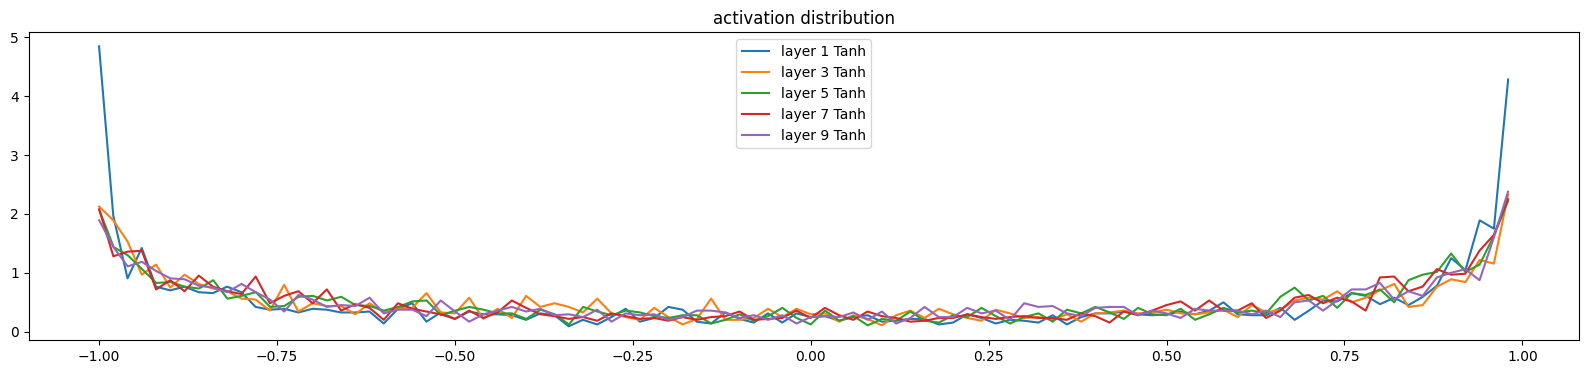

In [120]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out
    print(f"layer {i} {layer.__class__.__name__:10s}: mean {t.mean():+.2f}, std: {t.std():.2f}, saturated {(t.abs() > 0.97).float().mean()*100:.2f}%")
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} {layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 Tanh      : mean +0.00, std: 0.00, saturated 0.00%
layer 3 Tanh      : mean -0.00, std: 0.00, saturated 0.00%
layer 5 Tanh      : mean +0.00, std: 0.00, saturated 0.00%
layer 7 Tanh      : mean -0.00, std: 0.00, saturated 0.00%
layer 9 Tanh      : mean -0.00, std: 0.00, saturated 0.00%


Text(0.5, 1.0, 'gradient distribution')

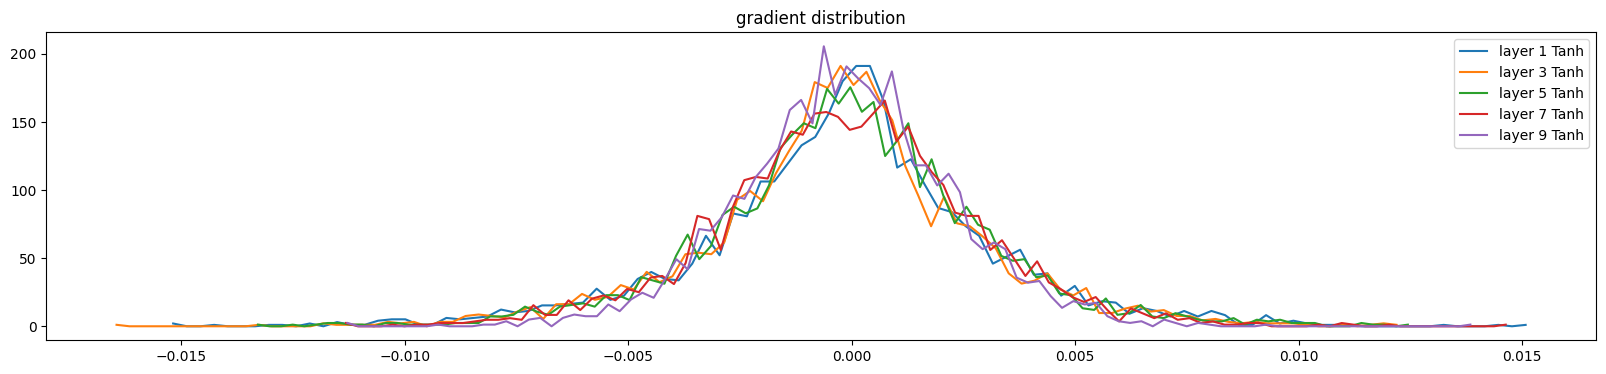

In [103]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print(f"layer {i} {layer.__class__.__name__:10s}: mean {t.mean():+.2f}, std: {t.std():.2f}, saturated {(t.abs() > 0.97).float().mean()*100:.2f}%")
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} {layer.__class__.__name__}')

plt.legend(legends);
plt.title('gradient distribution')

weight (27, 10) | mean -0.000428 | std 1.063419e-02 | grad: data ratio 1.099893e-02
weight (30, 100) | mean -0.000249 | std 9.848500e-03 | grad: data ratio 3.252528e-02
weight (100, 100) | mean +0.000022 | std 7.935246e-03 | grad: data ratio 4.723344e-02
weight (100, 100) | mean +0.000002 | std 7.054896e-03 | grad: data ratio 4.218353e-02
weight (100, 100) | mean +0.000005 | std 6.552489e-03 | grad: data ratio 3.843160e-02
weight (100, 100) | mean -0.000055 | std 5.608104e-03 | grad: data ratio 3.337003e-02
weight (100, 27) | mean -0.000000 | std 2.066621e-02 | grad: data ratio 2.999767e-01


Text(0.5, 1.0, 'gradient distribution')

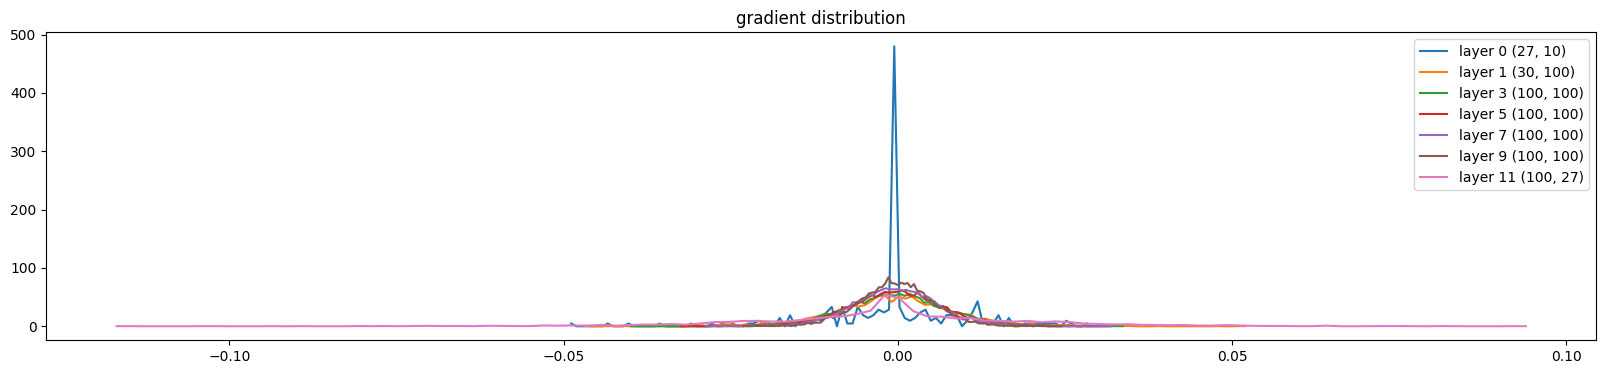

In [104]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print(f"weight {tuple(p.shape)} | mean {t.mean():+f} | std {t.std():e} | grad: data ratio {(t.std() / p.std()):e}")
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} {tuple(p.shape)}')

plt.legend(legends);
plt.title('gradient distribution')

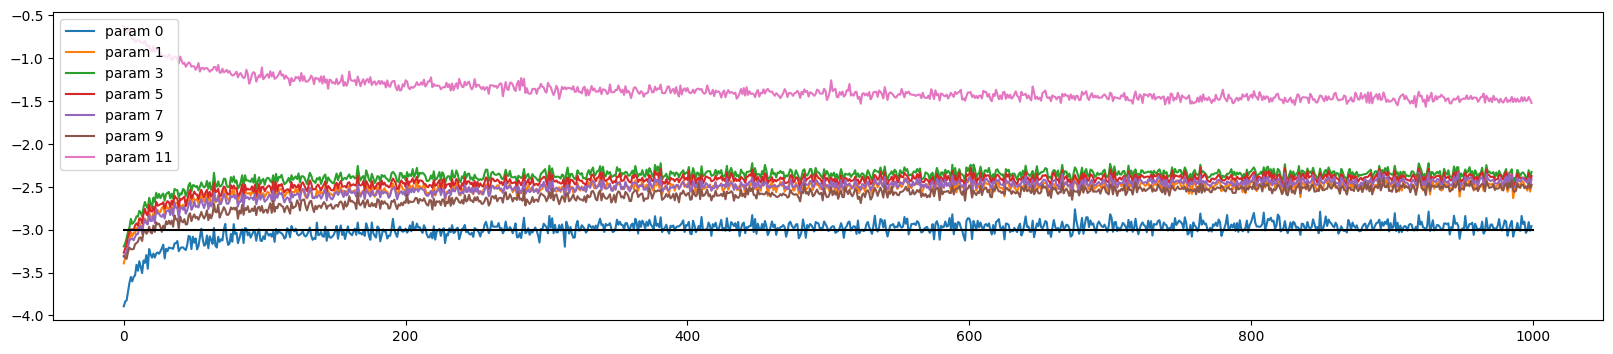

In [105]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append(f'param {i}')

plt.plot([0 , len(ud)], [-3, -3], 'k')
plt.legend(legends);

## Bringing back BatchNorm

In [126]:
n_embd = 10  # dimensionality of char embedding vectors
n_hidden = 100  # number of neurons in the hidden layer
g = torch.Generator().manual_seed(123321)

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
  # last layer
  layers[-1].gamma *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

47024


In [127]:
max_steps = 1000
batch_size = 32
lossi = []
ud = [] # update
for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]    # batch

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, Yb)   # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad()

  for p in parameters:
    p.grad = None

  loss.backward()

  # update
  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

  # track
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

  with torch.no_grad():
    ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])


      0/   1000: 3.2945


layer 2 Tanh      : mean -0.00, std: 0.64, saturated 2.59%
layer 5 Tanh      : mean -0.01, std: 0.64, saturated 2.88%
layer 8 Tanh      : mean +0.00, std: 0.64, saturated 2.53%
layer 11 Tanh      : mean +0.00, std: 0.64, saturated 2.03%
layer 14 Tanh      : mean -0.00, std: 0.65, saturated 1.50%


Text(0.5, 1.0, 'activation distribution')

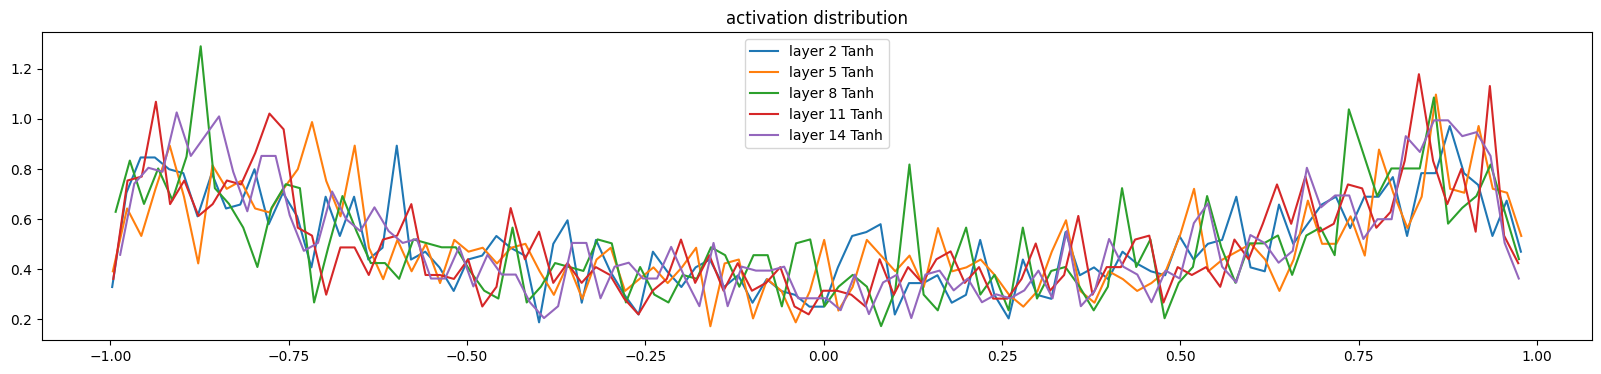

In [128]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out
    print(f"layer {i} {layer.__class__.__name__:10s}: mean {t.mean():+.2f}, std: {t.std():.2f}, saturated {(t.abs() > 0.97).float().mean()*100:.2f}%")
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} {layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 Tanh      : mean +0.00, std: 0.00, saturated 0.00%
layer 5 Tanh      : mean -0.00, std: 0.00, saturated 0.00%
layer 8 Tanh      : mean +0.00, std: 0.00, saturated 0.00%
layer 11 Tanh      : mean -0.00, std: 0.00, saturated 0.00%
layer 14 Tanh      : mean +0.00, std: 0.00, saturated 0.00%


Text(0.5, 1.0, 'gradient distribution')

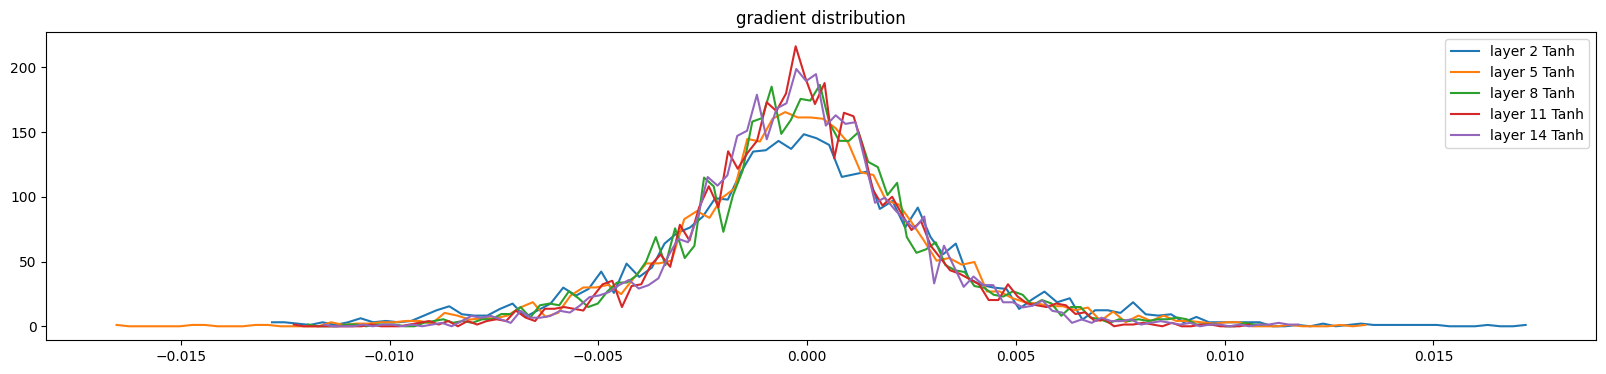

In [129]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print(f"layer {i} {layer.__class__.__name__:10s}: mean {t.mean():+.2f}, std: {t.std():.2f}, saturated {(t.abs() > 0.97).float().mean()*100:.2f}%")
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} {layer.__class__.__name__}')

plt.legend(legends);
plt.title('gradient distribution')

weight (27, 10) | mean -0.000000 | std 8.439647e-03 | grad: data ratio 8.712179e-03
weight (30, 100) | mean -0.000043 | std 8.540479e-03 | grad: data ratio 2.820471e-02
weight (100, 100) | mean +0.000020 | std 7.062478e-03 | grad: data ratio 4.223265e-02
weight (100, 100) | mean -0.000073 | std 5.922974e-03 | grad: data ratio 3.557414e-02
weight (100, 100) | mean -0.000129 | std 5.782274e-03 | grad: data ratio 3.403999e-02
weight (100, 100) | mean -0.000124 | std 5.314219e-03 | grad: data ratio 3.169346e-02
weight (100, 27) | mean -0.000108 | std 1.001766e-02 | grad: data ratio 5.866990e-02


Text(0.5, 1.0, 'gradient distribution')

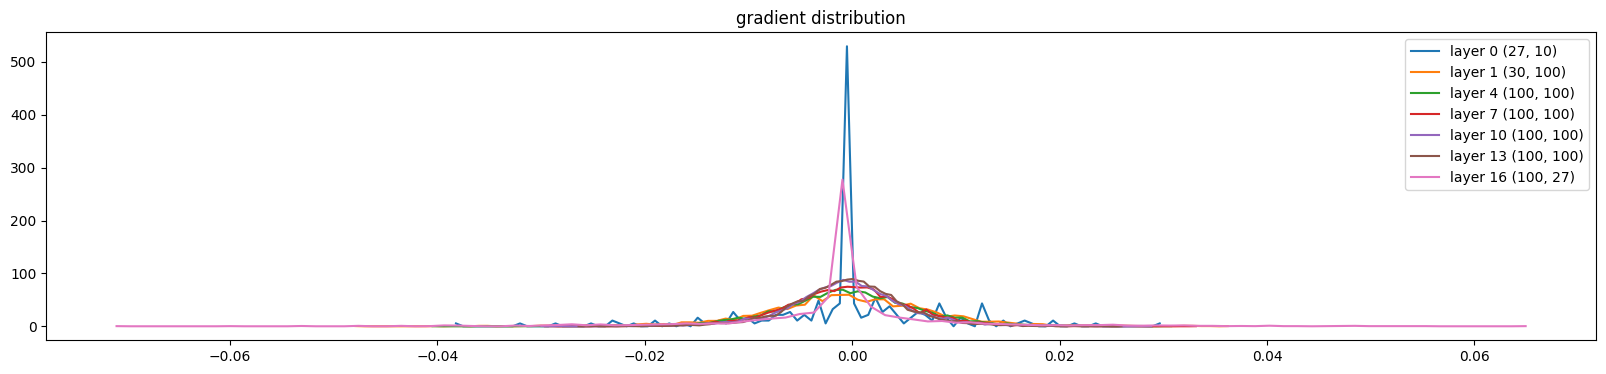

In [131]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print(f"weight {tuple(p.shape)} | mean {t.mean():+f} | std {t.std():e} | grad: data ratio {(t.std() / p.std()):e}")
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} {tuple(p.shape)}')

plt.legend(legends);
plt.title('gradient distribution')

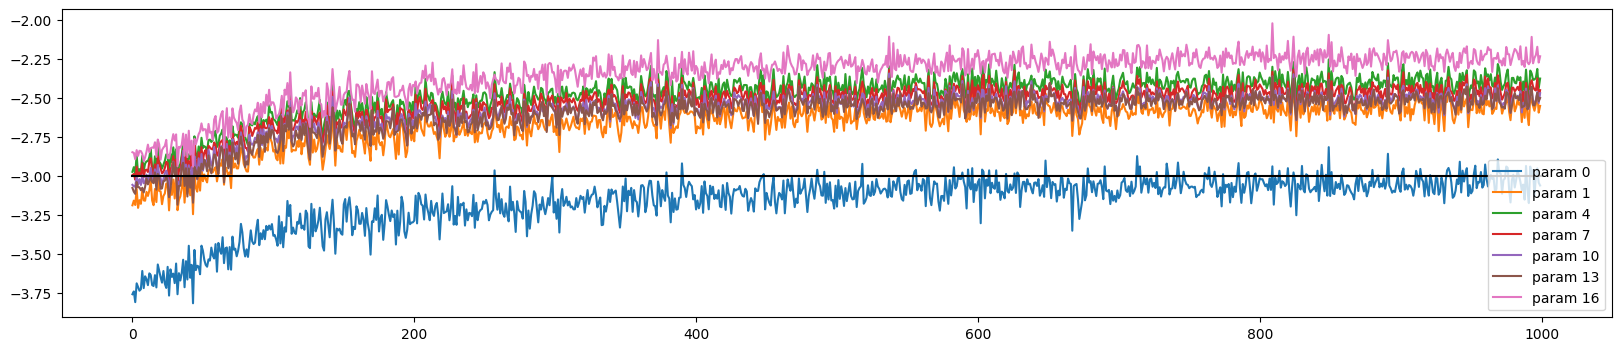

In [130]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append(f'param {i}')

plt.plot([0 , len(ud)], [-3, -3], 'k')
plt.legend(legends);